<a href="https://colab.research.google.com/github/Aakash-kaushik/obj_det_calam/blob/master/obj_det.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pafy youtube_dl
!wget https://scx1.b-cdn.net/csz/news/800/2016/a15dayexperi.jpg https://images.theconversation.com/files/329407/original/file-20200421-82654-a3vu4k.jpg

     |████████████████████████████████| 1.8MB 5.5MB/s 
--2020-07-24 14:39:15--  https://scx1.b-cdn.net/csz/news/800/2016/a15dayexperi.jpg
Resolving scx1.b-cdn.net (scx1.b-cdn.net)... 45.35.205.78
Connecting to scx1.b-cdn.net (scx1.b-cdn.net)|45.35.205.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘a15dayexperi.jpg’

a15dayexperi.jpg        [ <=>                ]  20.75K  --.-KB/s    in 0.06s   

2020-07-24 14:39:16 (356 KB/s) - ‘a15dayexperi.jpg’ saved [21253]

--2020-07-24 14:39:16--  https://images.theconversation.com/files/329407/original/file-20200421-82654-a3vu4k.jpg
Resolving images.theconversation.com (images.theconversation.com)... 151.101.202.208, 2a04:4e42:2f::720
Connecting to images.theconversation.com (images.theconversation.com)|151.101.202.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58595 (57K) [image/jpeg]
Saving to: ‘file-20200421-82654-a3vu4k.jpg’

file-20200421-82654 

In [ ]:
import numpy as np
import cv2
import pafy
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image

import torch
from torch import nn
from torchvision import transforms

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

utils=torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

def youtube_cap(url):
  play=pafy.new(url).streams[-1]
  assert play is not None
  return cv2.VideoCapture(play.url)

class obj_det_pipeline:
  def __init__(self,device=device,thres=0.5,cmap_name="tab10_r",obj_to_detect=["cell phone","person"]):
    self.transform=transforms.Compose([transforms.Resize(300),
                                       transforms.CenterCrop(300),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                     ])
    self.model=torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd').eval().to(device)

    for param in self.model.parameters():
      param.requires_grad=False
    
    self.device=device
    self.thres=thres
    self.obj_to_detect=obj_to_detect
    self.cmap=cm.get_cmap(cmap_name)
    self.classes_to_labels=utils.get_coco_object_dictionary()

  @staticmethod
  def img_crop(img):
        if len(img.shape) == 3:
            y = img.shape[0]
            x = img.shape[1]
        elif len(img.shape) == 4:
            y = img.shape[1]
            x = img.shape[2]
        else:
            raise ValueError(f"Image shape: {img.shape} invalid")

        out_size = min((y, x))
        startx = x // 2 - out_size // 2
        starty = y // 2 - out_size // 2

        if len(img.shape) == 3:
            return img[starty:starty+out_size, startx:startx+out_size]
        elif len(img.shape) == 4:
            return img[:, starty:starty+out_size, startx:startx+out_size]


  def box_plot(self, output_img, labels, boxes):
        for label, (x1, y1, x2, y2) in zip(labels, boxes):
            if (x2 - x1) * (y2 - y1) < 0.25:

                x1 = int(x1*output_img.shape[1])
                y1 = int(y1*output_img.shape[0])
                x2 = int(x2*output_img.shape[1])
                y2 = int(y2*output_img.shape[0])

                rgba = self.cmap(label)
                bgr = rgba[2]*255, rgba[1]*255, rgba[0]*255
                if self.classes_to_labels[label - 1] in self.obj_to_detect:
                  cv2.rectangle(output_img, (x1, y1), (x2, y2), bgr, 2)
                  cv2.putText(output_img, self.classes_to_labels[label - 1], (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, bgr, 2)

        return output_img

  def __call__(self, img):
    if type(img)==np.ndarray:
      pil_img=Image.fromarray(img[:,:,::-1])
      img_tensor=self.transform(pil_img)
      img_tensor=img_tensor.unsqueeze(0).to(self.device)
      outputs=self.model(img_tensor)
      results=utils.decode_results(outputs)
      boxes,labels,conf=utils.pick_best(results[0],self.thres)
      output_img=self.img_crop(img)
      return self.box_plot(output_img,labels,boxes)
      
    elif type(img) == list:
            # batch case
            if len(img) == 0:
                # Catch empty batch case
                return None
            pil_img=[Image.fromarray(x[:,:,::-1]) for x in img]
            transform_img=[self.transform(x) for x in pil_img]
            tensor_batch = [torch.unsqueeze(x,0).to(self.device) for x in transform_img] 
            tensor_batch=torch.cat(tensor_batch)
            assert torch.is_tensor(tensor_batch) is True
            output_batch=self.model(tensor_batch)
            results = utils.decode_results(output_batch)

            output_imgs = []
            for im, result in zip(img, results):
                boxes, labels, conf = utils.pick_best(result, self.thres)
                output_imgs.append(self.box_plot(self.img_crop(im), labels, boxes))

            return output_imgs

    else:
      raise TypeError(f"Not understood")

obj_detect = obj_det_pipeline(device="cuda", thres=0.4) #pass obj_to_detect as list of items to detect

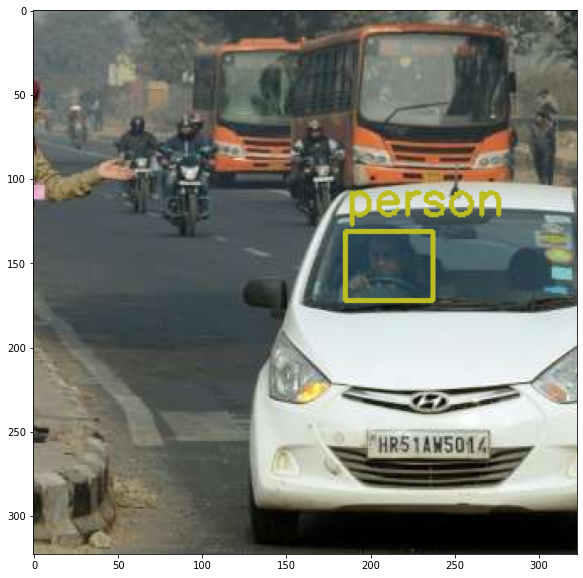

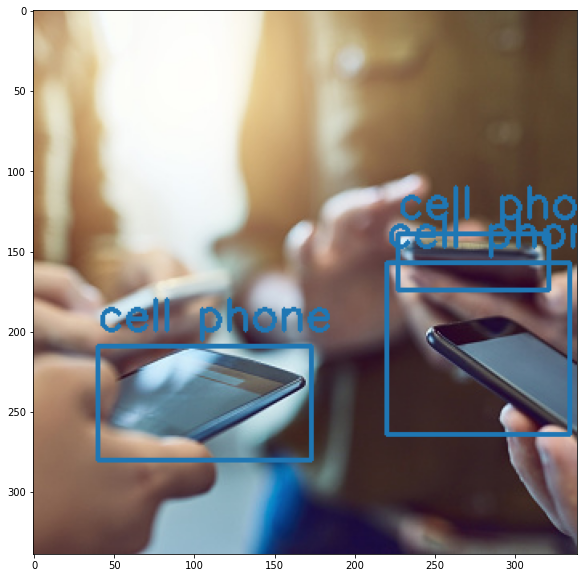

In [ ]:
"Image"
img_list=["/content/a15dayexperi.jpg","/content/file-20200421-82654-a3vu4k.jpg"]

for img_path in img_list:
  frame=cv2.imread(img_path)
  plt.figure(figsize=(10,10))
  plt.imshow(obj_detect(frame)[:,:,::-1])
  plt.show()

In [ ]:
"video"
batch_size = 64

cap = youtube_cap("https://youtu.be/U-UYK4nahoo")
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

size = min([width, height])

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter("obj_det_try.avi", fourcc, 15, (size, size))


exit_flag = True
while exit_flag:
    batch_inputs = []
    for _ in range(batch_size):
        ret, frame = cap.read()
        if ret:
            batch_inputs.append(frame)
        else:
            exit_flag = False
            break

    outputs = obj_detect(batch_inputs)
    if outputs is not None:
        for output in outputs:
            out.write(output)
    else:
        exit_flag = False

cap.release()
out.release()